## Getting Startetd

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
!wget https://raw.githubusercontent.com/codernayeem/dl-practice/main/utils.py
import utils

--2021-07-07 20:35:12--  https://raw.githubusercontent.com/codernayeem/dl-practice/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14105 (14K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  13.77K  --.-KB/s    in 0s      

2021-07-07 20:35:12 (106 MB/s) - ‘utils.py’ saved [14105/14105]



## Downloading and visualise our images dataset

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir

228818944/228813984 [==============================] - 3s 0us/step


'/root/.keras/datasets/flower_photos'

In [4]:
utils.print_class_files(data_dir)

Directory : /root/.keras/datasets/flower_photos
  - Found 799 tulips
  - Found 641 roses
  - Found 633 daisy
  - Found 699 sunflowers
  - Found 898 dandelion


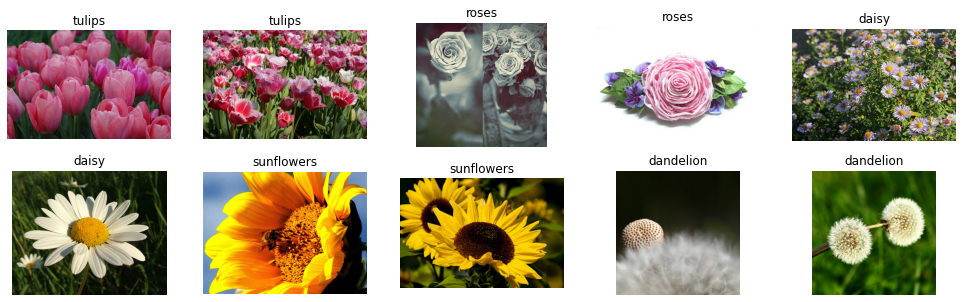

In [52]:
utils.plot_images(*utils.get_random_imgs(data_dir, equal_img_per_class=2), from_dir=True, single_figsize=(3.4, 2.5))

## Imporing our dataset using `keras`

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SEED = 105

In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                    label_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMAGE_SIZE,
                                                    seed=SEED,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    )

val_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                    label_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMAGE_SIZE,
                                                    seed=SEED,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
print('Total Batches :', len(train_data), '+', len(val_data))

Total Batches : 92 + 23


In [9]:
class_names = train_data.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

#### Again Visualise

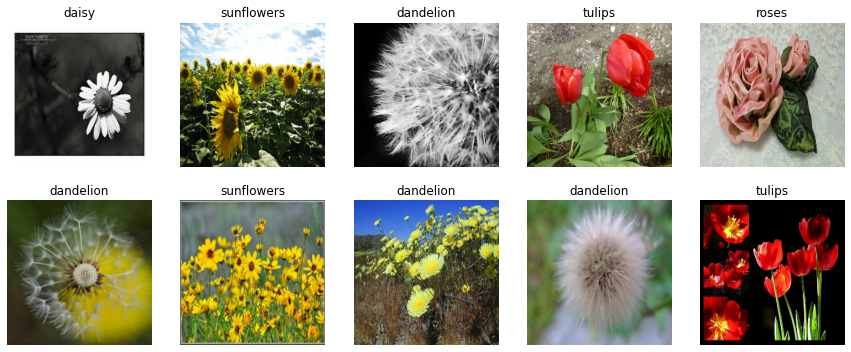

In [10]:
# our images gets resized when using `image_dataset_from_directory()`
# As a result, the numbers become int o float but remain in (0 - 255) range
# So, to visualise, we need to devide our imgs by 255
# So that the range become (0 - 1) [as the dtype=float]
for images, labels in train_data.take(1):
  utils.plot_images(images[:10]/255, labels[:10], label_mode='categorical', classes=class_names, single_figsize=(3, 3))

## Building Model

### Prepare our Models roadmap
#### We will make 4 models
| Models | Task          | API |
| ------ | ------------- | --- |
| Model_0 (Base) | Very simple **CNN** model | *Sequential* |
| Model_1 | **CNN** model with **data augmentation** | *Sequential* |
| Model_2 | Using **EfficientNetB0** application (**feature extractor**) | **Functional** |
| Model_3 | Using EfficientNetB0 application (**fine tuning**)| **Functional** |

### **Model_0** (Simple CNN)

In [11]:
num_class = len(class_names)
num_class

5

In [12]:
model_0 = Sequential([
        layers.InputLayer(input_shape=(*IMAGE_SIZE, 3)),
        layers.experimental.preprocessing.Rescaling(1/255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 3, activation='relu'),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(num_class, activation='softmax'),
])
model_0.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 16)      2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 107, 107, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 16)        0

In [13]:
history_0 = model_0.fit(train_data, epochs=10,
                        batch_size=32,
                        callbacks=[utils.create_tensorboard_callback('flower_logs', 'model_0')],
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Saving TensorBoard log files to: flower_logs/model_0/20210707-203528
Epoch 1/10
92/92 [==============================] - 43s 116ms/step - loss: 1.5050 - accuracy: 0.3334 - val_loss: 1.2246 - val_accuracy: 0.4714
Epoch 2/10
92/92 [==============================] - 10s 100ms/step - loss: 1.0893 - accuracy: 0.5593 - val_loss: 1.2148 - val_accuracy: 0.5136
Epoch 3/10
92/92 [==============================] - 9s 99ms/step - loss: 0.9501 - accuracy: 0.6373 - val_loss: 1.0971 - val_accuracy: 0.5586
Epoch 4/10
92/92 [==============================] - 9s 99ms/step - loss: 0.6964 - accuracy: 0.7405 - val_loss: 1.1377 - val_accuracy: 0.5804
Epoch 5/10
92/92 [==============================] - 10s 101ms/step - loss: 0.4904 - accuracy: 0.8294 - val_loss: 1.4689 - val_accuracy: 0.5518
Epoch 6/10
92/92 [==============================] - 10s 100ms/step - loss: 0.2893 - accuracy: 0.9009 - val_loss: 2.0254 - val_accuracy: 0.4864
Epoch 7/10
92/92 [==============================] - 10s 100ms/step - loss: 0.

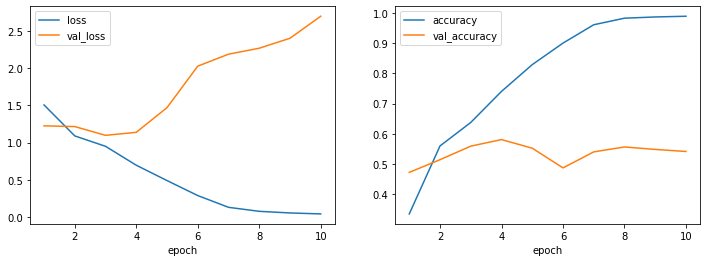

In [14]:
utils.plot_history(history_0)

We can see that, our model is clearly overfiting. Let's try data augmentation with this model

### **Model_1** (CNN + Data Augmentation)

In [15]:
data_aug = Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.Rescaling(1./255) # remove for EfficientNetB0
], name ="data_augmentation_with_rescaling")

In [16]:
model_1 = Sequential([
  layers.InputLayer(input_shape=(*IMAGE_SIZE, 3)),
  data_aug,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, activation='relu'),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.GlobalAveragePooling2D(),
  layers.Flatten(),
  layers.Dense(num_class, activation='softmax'),
])
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation_with_resca (None, None, None, 3)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 16)   

In [17]:
history_1 = model_1.fit(train_data, epochs=10,
                        batch_size=32,
                        callbacks=[utils.create_tensorboard_callback('flower_logs', 'model_1')],
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Saving TensorBoard log files to: flower_logs/model_1/20210707-203820
Epoch 1/10
92/92 [==============================] - 75s 797ms/step - loss: 1.5295 - accuracy: 0.3076 - val_loss: 1.3658 - val_accuracy: 0.4591
Epoch 2/10
92/92 [==============================] - 70s 759ms/step - loss: 1.3140 - accuracy: 0.4315 - val_loss: 1.2684 - val_accuracy: 0.4005
Epoch 3/10
92/92 [==============================] - 70s 753ms/step - loss: 1.2585 - accuracy: 0.4275 - val_loss: 1.2505 - val_accuracy: 0.4251
Epoch 4/10
92/92 [==============================] - 73s 791ms/step - loss: 1.2445 - accuracy: 0.4380 - val_loss: 1.2476 - val_accuracy: 0.4019
Epoch 5/10
92/92 [==============================] - 70s 753ms/step - loss: 1.2287 - accuracy: 0.4639 - val_loss: 1.2274 - val_accuracy: 0.4251
Epoch 6/10
92/92 [==============================] - 65s 700ms/step - loss: 1.1981 - accuracy: 0.4819 - val_loss: 1.2095 - val_accuracy: 0.4946
Epoch 7/10
92/92 [==============================] - 66s 712ms/step - loss

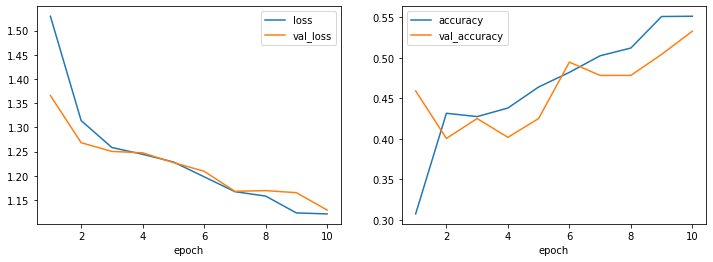

In [18]:
utils.plot_history(history_1)

Looks like our model is improving but very slowly and may be it's underfitting as we got low accuracy. Let's try transfer learning feature extracion to improve our model.

### **Model_2** (EfficientNetB0 Applicaion with Functional API) (Feature Exraction)

Now we will make a feaure extractor model, which we are gonna use for fine-tuning later on model_3

In [19]:
data_aug_2 = Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name ="data_augmentation_layer")

In [20]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(*IMAGE_SIZE, 3), name="input_layer")
x = data_aug_2(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(num_class, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model_2.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


Let's create a `ModelCheckPoint` Callback

In [21]:
checkpoint_path = "model_2_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [22]:
init_epochs = 5
history_2 = model_2.fit(train_data, epochs=init_epochs,
                        batch_size=32,
                        callbacks=[utils.create_tensorboard_callback('flower_logs', 'model_2'), checkpoint_callback],
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Saving TensorBoard log files to: flower_logs/model_2/20210707-205054
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


92/92 [==============================] - 43s 412ms/step - loss: 0.8313 - accuracy: 0.7197 - val_loss: 0.5088 - val_accuracy: 0.8229

Epoch 00001: saving model to model_2_checkpoint_weights/checkpoint.ckpt
Epoch 2/5
92/92 [==============================] - 28s 305ms/step - loss: 0.4612 - accuracy: 0.8491 - val_loss: 0.4087 - val_accuracy: 0.8501

Epoch 00002: saving model to model_2_checkpoint_weights/checkpoint.ckpt
Epoch 3/5
92/92 [==============================] - 26s 283ms/step - loss: 0.3763 - accuracy: 0.8750 - val_loss: 0.3516 - val_accuracy: 0.8719

Epoch 00003: saving model to model_2_checkpoint_weights/checkpoint.ckpt
Epoch 4/5
92/92 [==============================] - 25s 264ms/step - loss: 0.3376 - accuracy: 0.8879 - val_loss: 0.3208 - val_accuracy: 0.8760

Epoch 00004: saving model to model_2_checkpoint_weights/checkpoint.ckpt
Epoch 5/5
92/92 [==============================] - 24s 261ms/step - loss: 0.2960 - accuracy: 0.9026 - val_loss: 0.3064 - val_accuracy: 0.8828

Epoch 0

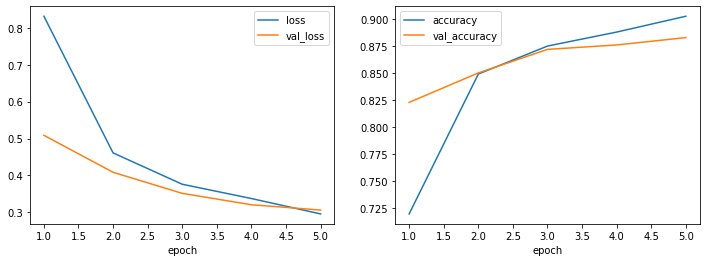

In [23]:
utils.plot_history(history_2)

In [24]:
res_2 = model_2.evaluate(val_data)
res_2

23/23 [==============================] - 3s 93ms/step - loss: 0.3064 - accuracy: 0.8828


[0.3063828945159912, 0.8828337788581848]

In [25]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
res_2_ = model_2.evaluate(val_data)
res_2_

23/23 [==============================] - 2s 93ms/step - loss: 0.3064 - accuracy: 0.8828


[0.30638283491134644, 0.8828337788581848]

In [26]:
print(res_2 == res_2_) # is both result is same
print(np.isclose(np.array(res_2), np.array(res_2_))) # is both result is very close
print(np.array(res_2) - np.array(res_2_)) # difference between two result

False
[ True  True]
[5.96046448e-08 0.00000000e+00]


So, our `ModelCheckPoint` callback worked perfectly. Now let's **Fine Tune** our model using this **model_2**

### **Model_3** (Fine Tune Model_2)

In [27]:
# Lets check which layers are trainable in model_2
for layer in model_2.layers:
  print(layer.name, '\t', layer.trainable)

input_layer 	 True
data_augmentation_layer 	 True
efficientnetb0 	 False
global_average_pooling_layer 	 True
output_layer 	 True


In [28]:
# Check which layers are tuneable (trainable) in base_model of model_2
[(layer_number, layer.name) for layer_number, layer in enumerate(base_model.layers) if layer.trainable]

[]

No layer of base model (EfficientNetB0) is trainable! Because, we set trainable=False for base_model in model_2

In [29]:
# copy model_checkpoint folders to colab and load (if needed)
# !cp -r "/content/drive/My Drive/colab_saved_data/flower_cassification/v1/model_2_checkpoint_weights" "/content"
# model_2.load_weights(checkpoint_path)

In [30]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [31]:
# trainable layers
[(layer_number, layer.name) for layer_number, layer in enumerate(base_model.layers) if layer.trainable]

[(227, 'block7a_se_squeeze'),
 (228, 'block7a_se_reshape'),
 (229, 'block7a_se_reduce'),
 (230, 'block7a_se_expand'),
 (231, 'block7a_se_excite'),
 (232, 'block7a_project_conv'),
 (233, 'block7a_project_bn'),
 (234, 'top_conv'),
 (235, 'top_bn'),
 (236, 'top_activation')]

In [32]:
# Fine tune for another 5 epochs
fine_tune_epochs = init_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_3 = model_2.fit(train_data, epochs=fine_tune_epochs,
                        batch_size=32,
                        callbacks=[utils.create_tensorboard_callback('flower_logs', 'model_3')],
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        initial_epoch=init_epochs)

Saving TensorBoard log files to: flower_logs/model_3/20210707-205345
Epoch 6/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


92/92 [==============================] - 33s 303ms/step - loss: 0.2638 - accuracy: 0.9029 - val_loss: 0.2755 - val_accuracy: 0.8842
Epoch 7/10
92/92 [==============================] - 23s 247ms/step - loss: 0.2202 - accuracy: 0.9234 - val_loss: 0.2580 - val_accuracy: 0.8856
Epoch 8/10
92/92 [==============================] - 22s 231ms/step - loss: 0.1940 - accuracy: 0.9339 - val_loss: 0.2585 - val_accuracy: 0.8910
Epoch 9/10
92/92 [==============================] - 22s 238ms/step - loss: 0.1696 - accuracy: 0.9407 - val_loss: 0.2283 - val_accuracy: 0.9019
Epoch 10/10
92/92 [==============================] - 22s 233ms/step - loss: 0.1401 - accuracy: 0.9530 - val_loss: 0.2195 - val_accuracy: 0.9101


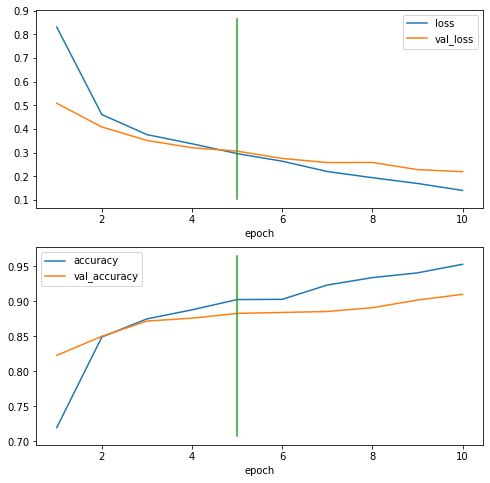

In [33]:
utils.compare_histories(history_2, history_3, initial_epochs=5)

Alright, alright, seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

In [34]:
model_2.evaluate(val_data)

23/23 [==============================] - 3s 96ms/step - loss: 0.2195 - accuracy: 0.9101


[0.21950416266918182, 0.9100817441940308]

Well, we got 90%+ Accuracy after fine tuning

## Conclusion

We got our model

In [35]:
# saving model
model_2.save('model_2_fine_tuned')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model_2_fine_tuned/assets


In [36]:
# let's save our things to gdrive
# mount your drive
drive = utils.mount_gdrive()
drive

Mounted at /content/drive


'/content/drive/My Drive'

In [37]:
# copying checkpoint to google drive
!cp -r "model_2_checkpoint_weights" "/content/drive/My Drive/colab_saved_data/flower_cassification/v1/"

In [38]:
# copying model to google drive for later use
!cp -r "model_2_fine_tuned" "/content/drive/My Drive/colab_saved_data/flower_cassification/v1/"

In [44]:
# copying tensorboard logs to google drive for later use
!cp -r "flower_logs" "/content/drive/My Drive/colab_saved_data/flower_cassification/v1/"

In [45]:
# saving class name and copying to gdrive
import json
with open('class_names.json', 'w') as fl:
    json.dump(class_names, fl)

!cp "class_names.json" "/content/drive/My Drive/colab_saved_data/flower_cassification/v1/"

## Tesing Our Model

In [46]:
# from gdrive
# !ls "/content/drive/My Drive/colab_saved_data/flower_cassification/v1/"
# path = "/content/drive/My Drive/colab_saved_data/flower_cassification/v1/model_2_fine_tuned'

# from colab
path = 'model_2_fine_tuned'

In [47]:
model = tf.keras.models.load_model(path)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 899,637
Non-trainable params: 3,156,339
_________________________________________________________________


In [48]:
# (if deleted)
# class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

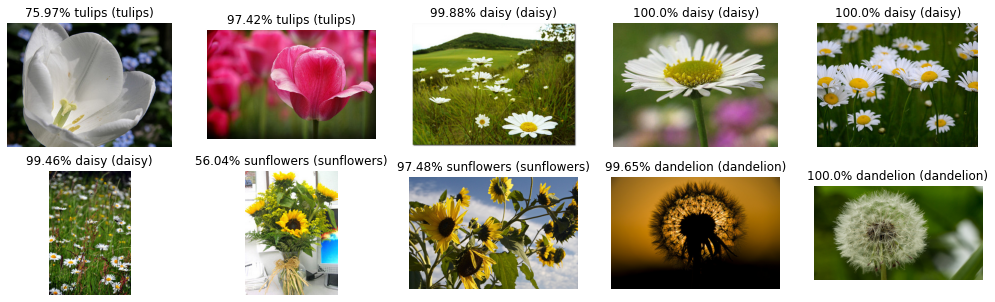

In [49]:
utils.plot_pred_images(model,
                       *utils.get_random_imgs(data_dir, rand_imgs=10, label_mode='int',  label_classes=class_names),
                       classes=class_names, IMAGE_SHAPE=IMAGE_SIZE, from_dir=True, single_figsize=(3.5, 2.5))

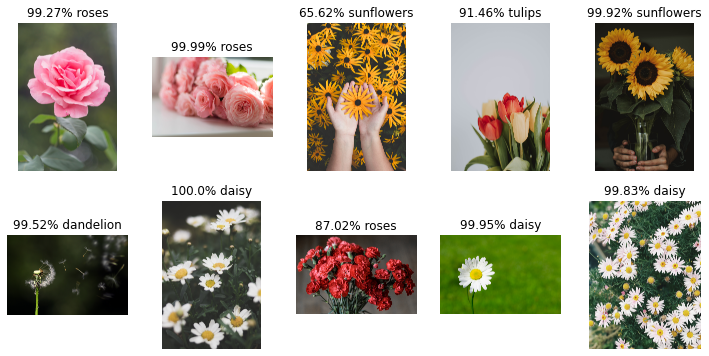

In [50]:
utils.plot_pred_images(model,
                       [
                        'https://images.pexels.com/photos/736230/pexels-photo-736230.jpeg',
                        'https://images.pexels.com/photos/617967/pexels-photo-617967.jpeg',
                        'https://images.pexels.com/photos/1697912/pexels-photo-1697912.jpeg',
                        'https://images.pexels.com/photos/2058498/pexels-photo-2058498.jpeg',
                        'https://images.pexels.com/photos/1390433/pexels-photo-1390433.jpeg',
                        'https://images.pexels.com/photos/289323/pexels-photo-289323.jpeg',
                        'https://images.pexels.com/photos/1166869/pexels-photo-1166869.jpeg',
                        'https://images.pexels.com/photos/136255/pexels-photo-136255.jpeg',
                        'https://images.pexels.com/photos/597055/spring-daisy-blossom-flora-597055.jpeg',
                        'https://images.pexels.com/photos/699964/pexels-photo-699964.jpeg',
                       ], classes=class_names, IMAGE_SHAPE=IMAGE_SIZE, from_link=True, single_figsize=(2.5, 3))

All right! Looks all good.